In [1]:
import numpy as np
import pandas as pd
from pydynpd import regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
#warnings.filterwarnings('ignore')

class SadoonReplication:
    def __init__(self, seed=None):
        """
        Clase para replicar las simulaciones de Sadoon et al. (2019)
        
        Parámetros:
        -----------
        seed : int, opcional
            Semilla para reproducibilidad (usar últimos 5 dígitos de tu documento)
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Parámetros base del experimento
        self.rho_values = [0.25, 0.50, 0.75]
        self.n_values = [500, 5000]
        self.T_total = 20  # Se generan 20 períodos
        self.T_discard = 13  # Se descartan los primeros 13
        self.T_effective = self.T_total - self.T_discard  # T efectivo = 7
        self.n_replications = 10
        self.prob_selection = 0.85  # P(d*_it > 0) = 0.85
        
    def generate_data(self, N, rho, selection_model='A', endogenous=True):
        """
        Genera datos según el DGP del paper
        
        Parámetros:
        -----------
        N : int
            Tamaño de muestra (individuos)
        rho : float
            Parámetro autoregresivo
        selection_model : str, 'A' o 'B'
            'A': selección estática, 'B': selección dinámica
        endogenous : bool
            Si True, genera selección endógena
        """
        # Generación de componentes de error
        eta_i = np.random.normal(0, 1, N)  # Heterogeneidad en selección
        u_it = np.random.normal(0, 1, (N, self.T_total))  # Error tiempo-variante selección
        
        if endogenous:
            # Selección endógena: correlación entre componentes
            alpha0_i = np.random.normal(0, 1, N)
            alpha_i = alpha0_i + 0.5 * eta_i  # corr(α_i, η_i) = 0.447
            
            epsilon0_it = np.random.normal(0, 1, (N, self.T_total))
            epsilon_it = epsilon0_it + 0.5 * u_it  # corr(ε_it, u_it) = 0.447
        else:
            # Selección exógena: sin correlación
            alpha_i = np.random.normal(0, 1, N)
            epsilon_it = np.random.normal(0, 1, (N, self.T_total))
        
        # Variable exógena para selección
        z_it = np.random.normal(0, 1, (N, self.T_total))
        
        # Ajustar 'a' para lograr P(d*_it > 0) = 0.85
        # Aproximación: a ≈ 1.04 para lograr P = 0.85
        a = stats.norm.ppf(self.prob_selection)
        
        # Generar ecuación de selección
        d_star = np.zeros((N, self.T_total))
        d_obs = np.zeros((N, self.T_total))
        
        for t in range(self.T_total):
            if selection_model == 'A':
                # Modelo estático: d*_it = a - z_it - η_i - u_it
                d_star[:, t] = a - z_it[:, t] - eta_i - u_it[:, t]
            else:  # Modelo B (dinámico)
                if t == 0:
                    # Primera observación (sin rezago)
                    d_star[:, t] = a - z_it[:, t] - eta_i - u_it[:, t]
                else:
                    # d*_it = a - 0.5*d_it-1 + z_it - η_i - u_it
                    d_star[:, t] = a - 0.5 * d_obs[:, t-1] + z_it[:, t] - eta_i - u_it[:, t]
            
            d_obs[:, t] = (d_star[:, t] > 0).astype(int)
        
        # Generar variable de resultado y*_it
        y_star = np.zeros((N, self.T_total))
        
        # Condición inicial (t=0)
        y_star[:, 0] = (2 + alpha_i + epsilon_it[:, 0]) / (1 - rho)
        
        # Proceso autoregresivo (t=1, ..., T-1)
        for t in range(1, self.T_total):
            y_star[:, t] = 2 + rho * y_star[:, t-1] + alpha_i + epsilon_it[:, t]
        
        # Variable observada (solo cuando d_it = 1)
        y_obs = np.where(d_obs == 1, y_star, np.nan)
        
        # Descartar primeras 13 observaciones
        y_obs = y_obs[:, self.T_discard:]
        d_obs = d_obs[:, self.T_discard:]
        z_obs = z_it[:, self.T_discard:]
        
        return y_obs, d_obs, z_obs
    
    def create_panel_data(self, y_obs, d_obs, z_obs):
        """
        Convierte arrays a formato panel para pydynpd
        """
        N, T = y_obs.shape
        
        # Crear DataFrame en formato panel
        data = []
        for i in range(N):
            for t in range(T):
                data.append({
                    'id': i + 1,
                    'year': t + 1,
                    'y': y_obs[i, t],
                    'd': d_obs[i, t],
                    'z': z_obs[i, t]
                })
        
        df = pd.DataFrame(data)
        
        # Filtrar solo observaciones donde y es observada (d=1)
        # y que tengan al menos 3 períodos consecutivos para AB
        df_selected = df[df['d'] == 1].copy()
        
        # Contar observaciones consecutivas por individuo
        df_selected = df_selected.sort_values(['id', 'year'])
        df_selected['y_lag1'] = df_selected.groupby('id')['y'].shift(1)
        df_selected['y_lag2'] = df_selected.groupby('id')['y'].shift(2)
        
        # Mantener solo observaciones con al menos 2 rezagos (para AB)
        df_final = df_selected.dropna(subset=['y', 'y_lag1', 'y_lag2']).copy()
        
        return df_final
    
    def estimate_models(self, df):
        """
        Estima modelos Arellano-Bond y System GMM
        """
        results = {}
        
        try:
            # Arellano-Bond (first-difference)
            command_ab = 'y L1.y | gmm(y, 2:6) | nolevel'
            ab_result = regression.abond(command_ab, df, ['id', 'year'])
            results['AB'] = ab_result.params['L1.y']
        except:
            results['AB'] = np.nan
        
        try:
            # System GMM
            command_sys = 'y L1.y | gmm(y, 2:99)'
            sys_result = regression.abond(command_sys, df, ['id', 'year'])
            results['SYS'] = sys_result.params['L1.y']
        except:
            results['SYS'] = np.nan
        
        return results
    
    def run_simulation(self, N, rho, selection_model='A', endogenous=True):
        """
        Ejecuta una simulación completa con múltiples replicaciones
        """
        ab_estimates = []
        sys_estimates = []
        
        print(f"Ejecutando simulación: N={N}, ρ={rho}, Modelo={selection_model}, Endógeno={endogenous}")
        
        for rep in range(self.n_replications):
            if rep % 100 == 0:
                print(f"  Replicación {rep}/{self.n_replications}")
            
            # Generar datos
            y_obs, d_obs, z_obs = self.generate_data(N, rho, selection_model, endogenous)
            
            # Crear panel
            df = self.create_panel_data(y_obs, d_obs, z_obs)
            
            # Verificar que hay suficientes datos
            if len(df) < 10:  # Mínimo razonable de observaciones
                ab_estimates.append(np.nan)
                sys_estimates.append(np.nan)
                continue
            
            # Estimar modelos
            estimates = self.estimate_models(df)
            ab_estimates.append(estimates['AB'])
            sys_estimates.append(estimates['SYS'])
        
        # Calcular estadísticas
        ab_estimates = np.array(ab_estimates)
        sys_estimates = np.array(sys_estimates)
        
        # Remover NaN para cálculos
        ab_valid = ab_estimates[~np.isnan(ab_estimates)]
        sys_valid = sys_estimates[~np.isnan(sys_estimates)]
        
        results = {
            'rho_true': rho,
            'AB_bias': np.mean(ab_valid) - rho if len(ab_valid) > 0 else np.nan,
            'AB_se': np.std(ab_valid) if len(ab_valid) > 0 else np.nan,
            'SYS_bias': np.mean(sys_valid) - rho if len(sys_valid) > 0 else np.nan,
            'SYS_se': np.std(sys_valid) if len(sys_valid) > 0 else np.nan,
            'AB_valid_reps': len(ab_valid),
            'SYS_valid_reps': len(sys_valid)
        }
        
        return results
    
    def create_table_1_3(self):
        """
        Replica las Tablas 1-3 del paper
        """
        print("=== REPLICANDO TABLAS 1-3 ===")
        
        # Configuraciones para las tablas
        configs = [
            # Tabla 1 implícita: Sin selección endógena
            {'endogenous': False, 'title': 'Sin selección endógena'},
            # Tabla 1 principal: Con selección endógena
            {'endogenous': True, 'title': 'Con selección endógena'}
        ]
        
        all_results = {}
        
        for config in configs:
            print(f"\n--- {config['title']} ---")
            results = {}
            
            for selection_model in ['A', 'B']:
                print(f"\nModelo de selección {selection_model}:")
                results[selection_model] = {}
                
                for N in self.n_values:
                    results[selection_model][N] = {}
                    
                    for rho in self.rho_values:
                        sim_results = self.run_simulation(
                            N, rho, selection_model, config['endogenous']
                        )
                        results[selection_model][N][rho] = sim_results
            
            all_results[config['title']] = results
            
            # Imprimir tabla formateada
            self._print_formatted_table(results, config['title'])
        
        return all_results
    
    def _print_formatted_table(self, results, title):
        """
        Imprime tabla formateada similar al paper
        """
        print(f"\n{'='*50}")
        print(f"TABLA: {title}")
        print(f"{'='*50}")
        
        for selection_model in ['A', 'B']:
            print(f"\nModelo de selección {selection_model}:")
            print("-" * 40)
            
            for N in self.n_values:
                print(f"\nN = {N}")
                print("ρ\t\tAB Bias\t\tAB SE\t\tSYS Bias\tSYS SE")
                print("-" * 60)
                
                for rho in self.rho_values:
                    res = results[selection_model][N][rho]
                    print(f"{rho:.2f}\t\t{res['AB_bias']:.5f}\t\t{res['AB_se']:.5f}\t\t"
                          f"{res['SYS_bias']:.5f}\t\t{res['SYS_se']:.5f}")
    
    def create_figure_1(self):
        """
        Replica la Figura 1 del paper
        """
        print("\n=== REPLICANDO FIGURA 1 ===")
        
        # Diferentes tamaños de muestra para la figura
        sample_sizes = [200, 500, 1000, 2000, 3000, 4000, 5000]
        rho_test = 0.50  # Usar ρ = 0.50 para la figura
        
        results_fig = {
            'sample_sizes': sample_sizes,
            'AB_bias': [],
            'SYS_bias': []
        }
        
        # Ejecutar simulaciones para diferentes tamaños de muestra
        for N in sample_sizes:
            print(f"Simulando para N = {N}")
            
            # Simular con menos replicaciones para mayor velocidad
            original_reps = self.n_replications
            self.n_replications = 100  # Reducir para velocidad
            
            sim_results = self.run_simulation(N, rho_test, 'A', True)
            
            results_fig['AB_bias'].append(sim_results['AB_bias'])
            results_fig['SYS_bias'].append(sim_results['SYS_bias'])
            
            # Restaurar número original de replicaciones
            self.n_replications = original_reps
        
        # Crear la figura
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(sample_sizes, results_fig['AB_bias'], 'o-', label='AB', color='blue')
        plt.plot(sample_sizes, results_fig['SYS_bias'], 's-', label='System', color='red')
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Tamaño de muestra')
        plt.ylabel('Sesgo promedio')
        plt.title(f'ρ = {rho_test}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Repetir para otros valores de ρ
        for i, rho_val in enumerate([0.25, 0.75]):
            plt.subplot(2, 2, i+2)
            
            # Simular para este ρ
            ab_bias_rho = []
            sys_bias_rho = []
            
            for N in sample_sizes:
                sim_res = self.run_simulation(N, rho_val, 'A', True)
                ab_bias_rho.append(sim_res['AB_bias'])
                sys_bias_rho.append(sim_res['SYS_bias'])
            
            plt.plot(sample_sizes, ab_bias_rho, 'o-', label='AB', color='blue')
            plt.plot(sample_sizes, sys_bias_rho, 's-', label='System', color='red')
            plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            plt.xlabel('Tamaño de muestra')
            plt.ylabel('Sesgo promedio')
            plt.title(f'ρ = {rho_val}')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Figura 1: Sesgo promedio vs Tamaño de muestra', y=1.02)
        plt.show()
        
        return results_fig

# Función principal para ejecutar todo
def run_complete_replication(seed=12345):
    """
    Ejecuta la replicación completa
    
    Parámetros:
    -----------
    seed : int
        Últimos 5 dígitos de tu documento de identidad
    """
    print("Iniciando replicación de Sadoon et al. (2019)")
    print(f"Usando semilla: {seed}")
    
    # Crear instancia de la clase
    replicator = SadoonReplication(seed=seed)
    
    # Replicar tablas
    table_results = replicator.create_table_1_3()
    
    # Replicar figura
    figure_results = replicator.create_figure_1()
    
    print("\n" + "="*50)
    print("REPLICACIÓN COMPLETADA")
    print("="*50)
    
    return table_results, figure_results

Iniciando replicación de Sadoon et al. (2019)
Usando semilla: 3649
=== REPLICANDO TABLAS 1-3 ===

--- Sin selección endógena ---

Modelo de selección A:
Ejecutando simulación: N=500, ρ=0.25, Modelo=A, Endógeno=False
  Replicación 0/10
 Dynamic panel-data estimation, two-step difference GMM
 Group variable: id                              Number of obs = 582     
 Time variable: year                             Min obs per group: 0    
 Number of instruments = 6                       Max obs per group: 3    
 Number of groups = 459                          Avg obs per group: 1.27 
+------+-----------+---------------------+-----------+-----------+---+
|  y   |   coef.   | Corrected Std. Err. |     z     |   P>|z|   |   |
+------+-----------+---------------------+-----------+-----------+---+
| L1.y | 0.1255590 |      0.1197192      | 1.0487788 | 0.2942800 |   |
+------+-----------+---------------------+-----------+-----------+---+
Hansen test of overid. restrictions: chi(5) = 1.771 Prob >

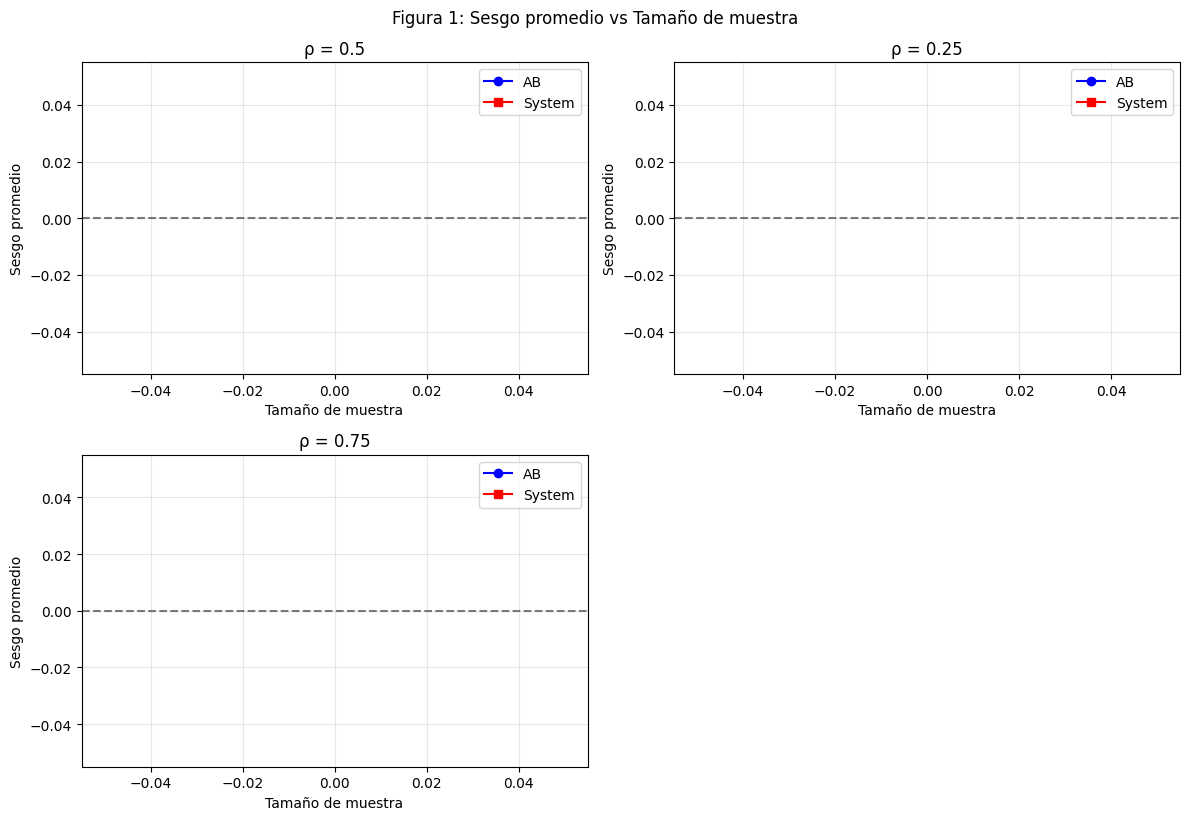


REPLICACIÓN COMPLETADA


In [7]:
# 1. Instalar dependencias
# pip install pydynpd matplotlib seaborn pandas numpy scipy

# 2. Cambiar la semilla por los últimos 5 dígitos de tu documento
mi_seed = int('03649')  # CAMBIAR AQUÍ

# 3. Ejecutar
resultados_tablas, resultados_figura = run_complete_replication(seed=mi_seed)

Estimando: N=500, rho=0.25, selección=A
Estimando: N=500, rho=0.25, selección=B
Estimando: N=500, rho=0.5, selección=A
Estimando: N=500, rho=0.5, selección=B
Estimando: N=500, rho=0.75, selección=A
Estimando: N=500, rho=0.75, selección=B
     N   rho selection  AB_bias  AB_se  SYS_bias  SYS_se  obs
0  500  0.25         A      NaN    NaN       NaN     NaN    0
1  500  0.25         B      NaN    NaN       NaN     NaN    0
2  500  0.50         A      NaN    NaN       NaN     NaN    0
3  500  0.50         B      NaN    NaN       NaN     NaN    0
4  500  0.75         A      NaN    NaN       NaN     NaN    0
5  500  0.75         B      NaN    NaN       NaN     NaN    0


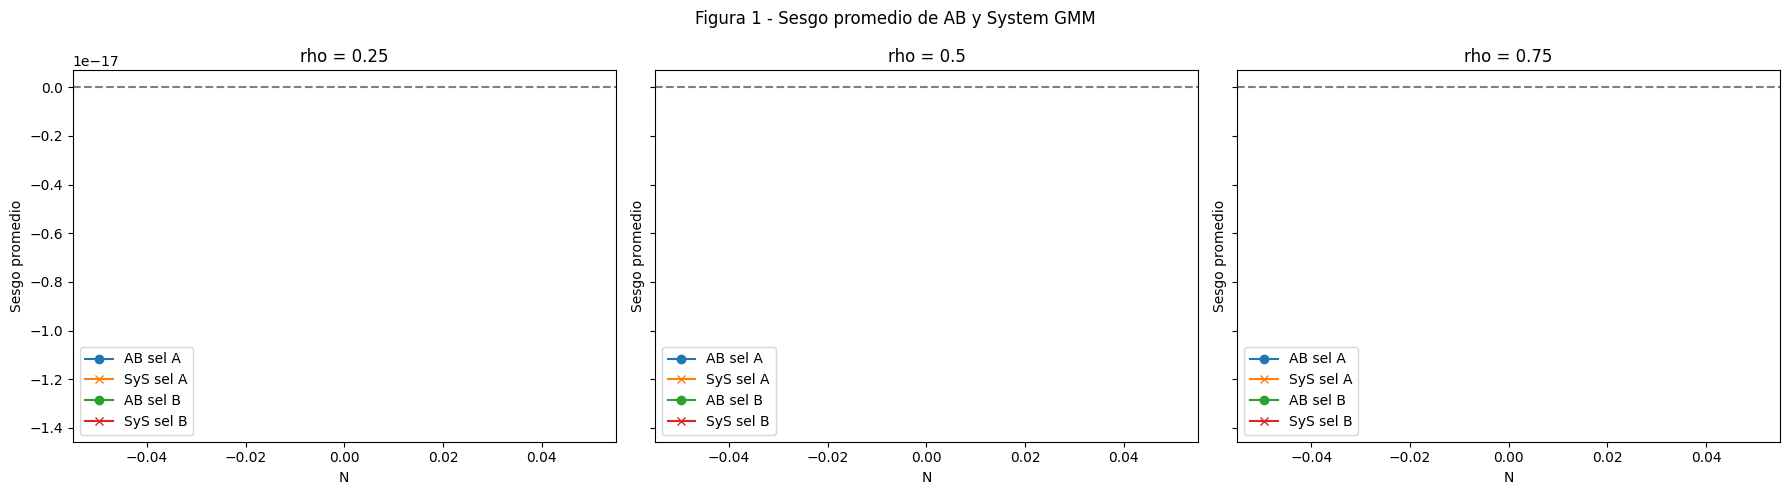

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydynpd import regression

# Semilla (últimos 5 dígitos del documento)
np.random.seed(int('03649'))

# Configuración
T_total = 20
T_drop = 13
T = T_total - T_drop
rho_values = [0.25, 0.5, 0.75]
N_list = [500]
selection_models = ['A', 'B']
reps = 500
selection_rate = 0.85

# Función de generación de datos
def generate_panel_data(N, rho, selection_type):
    sigma_eta = 1
    sigma_u = 1
    sigma_alpha0 = 1
    sigma_epsilon0 = 1

    eta_i = np.random.normal(0, sigma_eta, N)
    alpha0_i = np.random.normal(0, sigma_alpha0, N)
    alpha_i = alpha0_i + 0.5 * eta_i

    z = np.random.normal(0, 1, (N, T_total))
    u = np.random.normal(0, sigma_u, (N, T_total))
    epsilon0 = np.random.normal(0, sigma_epsilon0, (N, T_total))
    epsilon = epsilon0 + 0.5 * u

    y = np.zeros((N, T_total))
    y[:, 0] = (2 + alpha_i + epsilon[:, 0]) / (1 - rho)
    for t in range(1, T_total):
        y[:, t] = 2 + rho * y[:, t - 1] + alpha_i + epsilon[:, t]

    a = np.quantile(z + eta_i[:, None] + u, 1 - selection_rate)
    if selection_type == 'A':
        d_star = a - z - eta_i[:, None] - u
    elif selection_type == 'B':
        d_lag = np.zeros((N, T_total))
        d_lag[:, 1:] = (z[:, :-1] + eta_i[:, None] + u[:, :-1]) > 0
        d_star = a - 0.5 * d_lag + z - eta_i[:, None] - u
    else:
        raise ValueError("Tipo de selección no válido")

    d = (d_star > 0).astype(int)
    y, d = y[:, T_drop:], d[:, T_drop:]

    panel = []
    for i in range(N):
        for t in range(T):
            if t >= 2 and d[i, t] == d[i, t-1] == d[i, t-2] == 1:
                panel.append({
                    'id': i,
                    'year': t,
                    'n': y[i, t],
                    'L1.n': y[i, t - 1],
                    'L2.n': y[i, t - 2],
                })
    return pd.DataFrame(panel)

# Estimaciones
results = []
for N in N_list:
    for rho in rho_values:
        for sel_model in selection_models:
            print(f"Estimando: N={N}, rho={rho}, selección={sel_model}")
            biases_ab, biases_sys = [], []

            for _ in range(reps):
                df = generate_panel_data(N, rho, sel_model)
                if df.empty:
                    continue

                try:
                    # Arellano-Bond
                    cmd_ab = 'n L1.n L2.n | gmm(n, 2:99) | nolevel onestep'
                    model_ab = regression.abond(cmd_ab, df, ['id', 'year'])
                    coef_ab = model_ab.coefs_.get('L1.n', np.nan)

                    # System GMM
                    cmd_sys = 'n L1.n L2.n | gmm(n, 2:99)'
                    model_sys = regression.abond(cmd_sys, df, ['id', 'year'])
                    coef_sys = model_sys.coefs_.get('L1.n', np.nan)

                    # Guardar sesgos
                    if not np.isnan(coef_ab): biases_ab.append(coef_ab - rho)
                    if not np.isnan(coef_sys): biases_sys.append(coef_sys - rho)
                except:
                    continue

            results.append({
                'N': N,
                'rho': rho,
                'selection': sel_model,
                'AB_bias': np.mean(biases_ab),
                'AB_se': np.std(biases_ab),
                'SYS_bias': np.mean(biases_sys),
                'SYS_se': np.std(biases_sys),
                'obs': len(biases_ab)
            })

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)
#df_results.to_csv('tabla_biases.csv', index=False)
print(df_results)

# Figura 1: gráfico de sesgos según tamaño muestral y rho
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, rho in enumerate(rho_values):
    sub = df_results[df_results['rho'] == rho]
    for sel in ['A', 'B']:
        data = sub[sub['selection'] == sel]
        axs[i].plot(data['N'], data['AB_bias'], label=f'AB sel {sel}', marker='o')
        axs[i].plot(data['N'], data['SYS_bias'], label=f'SyS sel {sel}', marker='x')
    axs[i].axhline(0, color='gray', linestyle='--')
    axs[i].set_title(f'rho = {rho}')
    axs[i].set_xlabel('N')
    axs[i].set_ylabel('Sesgo promedio')
    axs[i].legend()

plt.suptitle('Figura 1 - Sesgo promedio de AB y System GMM')
plt.tight_layout()
#plt.savefig('figura_sesgo.png')
plt.show()

Estimando: N=500, rho=0.25, selección=A
 -> Replicaciones válidas: 500
Estimando: N=500, rho=0.25, selección=B
 -> Replicaciones válidas: 500
Estimando: N=500, rho=0.5, selección=A
 -> Replicaciones válidas: 500
Estimando: N=500, rho=0.5, selección=B
 -> Replicaciones válidas: 500
Estimando: N=500, rho=0.75, selección=A
 -> Replicaciones válidas: 500
Estimando: N=500, rho=0.75, selección=B
 -> Replicaciones válidas: 500

Resumen de resultados:
     N   rho selection  AB_bias  AB_se  SYS_bias  SYS_se  obs
0  500  0.25         A      NaN    NaN       NaN     NaN    0
1  500  0.25         B      NaN    NaN       NaN     NaN    0
2  500  0.50         A      NaN    NaN       NaN     NaN    0
3  500  0.50         B      NaN    NaN       NaN     NaN    0
4  500  0.75         A      NaN    NaN       NaN     NaN    0
5  500  0.75         B      NaN    NaN       NaN     NaN    0


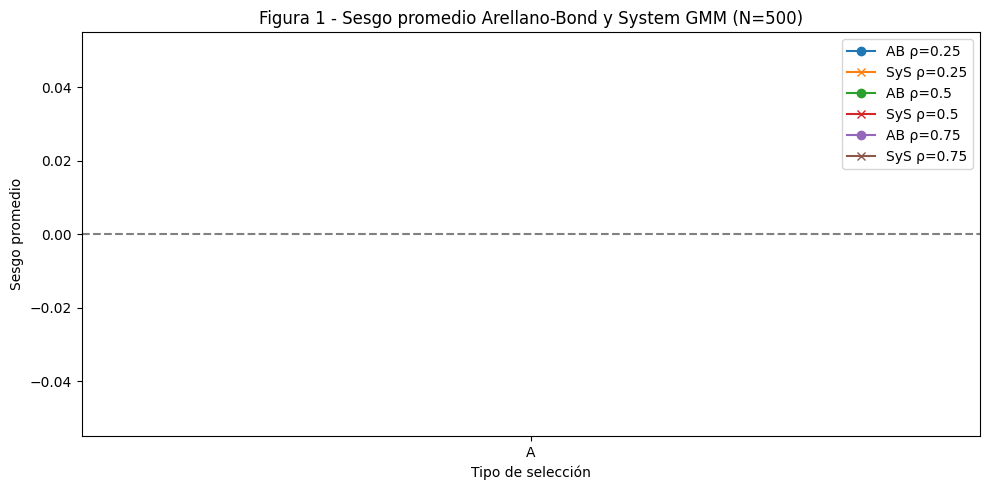

In [1]:
import numpy as np
import pandas as pd
from pydynpd import regression
import matplotlib.pyplot as plt

# Semilla fija (últimos 5 dígitos del documento)
np.random.seed(int('03649'))

# Configuración
T_total = 20
T_drop = 13
T = T_total - T_drop
rho_values = [0.25, 0.5, 0.75]
N_list = [500]
selection_models = ['A', 'B']
reps = 500
selection_rate = 0.85  # Solo documental, ahora usamos a = 0

# Función de generación de datos
def generate_panel_data(N, rho, selection_type):
    sigma_eta = 1
    sigma_u = 1
    sigma_alpha0 = 1
    sigma_epsilon0 = 1

    eta_i = np.random.normal(0, sigma_eta, N)
    alpha0_i = np.random.normal(0, sigma_alpha0, N)
    alpha_i = alpha0_i + 0.5 * eta_i

    z = np.random.normal(0, 1, (N, T_total))
    u = np.random.normal(0, sigma_u, (N, T_total))
    epsilon0 = np.random.normal(0, sigma_epsilon0, (N, T_total))
    epsilon = epsilon0 + 0.5 * u

    y = np.zeros((N, T_total))
    y[:, 0] = (2 + alpha_i + epsilon[:, 0]) / (1 - rho)
    for t in range(1, T_total):
        y[:, t] = 2 + rho * y[:, t - 1] + alpha_i + epsilon[:, t]

    # Fijar a para reproducibilidad
    a = 0

    if selection_type == 'A':
        d_star = a - z - eta_i[:, None] - u
    elif selection_type == 'B':
        d = np.zeros((N, T_total))  # inicializamos d para calcular su lag
        for t in range(1, T_total):
            d[:, t] = (z[:, t-1] - eta_i - u[:, t-1]) > 0
        d_star = a - 0.5 * d + z - eta_i[:, None] - u
    else:
        raise ValueError("Tipo de selección inválido")

    d = (d_star > 0).astype(int)

    y, d = y[:, T_drop:], d[:, T_drop:]

    panel = []
    for i in range(N):
        for t in range(2, T):
            if d[i, t] == d[i, t-1] == d[i, t-2] == 1:
                panel.append({
                    'id': i,
                    'year': t,
                    'n': y[i, t],
                    'L1.n': y[i, t - 1],
                    'L2.n': y[i, t - 2],
                })
    return pd.DataFrame(panel)

# Estimaciones
results = []
for N in N_list:
    for rho in rho_values:
        for sel_model in selection_models:
            print(f"Estimando: N={N}, rho={rho}, selección={sel_model}")
            biases_ab, biases_sys = [], []
            valid_panels = 0

            for _ in range(reps):
                df = generate_panel_data(N, rho, sel_model)
                if df.empty:
                    continue
                valid_panels += 1

                try:
                    # Arellano-Bond
                    cmd_ab = 'n L1.n L2.n | gmm(n, 2:99) | nolevel onestep'
                    model_ab = regression.abond(cmd_ab, df, ['id', 'year'])
                    coef_ab = model_ab.coefs_.get('L1.n', np.nan)

                    # System GMM
                    cmd_sys = 'n L1.n L2.n | gmm(n, 2:99)'
                    model_sys = regression.abond(cmd_sys, df, ['id', 'year'])
                    coef_sys = model_sys.coefs_.get('L1.n', np.nan)

                    if not np.isnan(coef_ab): biases_ab.append(coef_ab - rho)
                    if not np.isnan(coef_sys): biases_sys.append(coef_sys - rho)
                except Exception as e:
                    continue

            print(f" -> Replicaciones válidas: {valid_panels}")
            results.append({
                'N': N,
                'rho': rho,
                'selection': sel_model,
                'AB_bias': np.mean(biases_ab) if biases_ab else np.nan,
                'AB_se': np.std(biases_ab) if biases_ab else np.nan,
                'SYS_bias': np.mean(biases_sys) if biases_sys else np.nan,
                'SYS_se': np.std(biases_sys) if biases_sys else np.nan,
                'obs': len(biases_ab)
            })

# Guardar y mostrar resultados
df_results = pd.DataFrame(results)
#df_results.to_csv('tabla_biases.csv', index=False)
print("\nResumen de resultados:")
print(df_results)

# Figura 1 (si querés incluirla)
plt.figure(figsize=(10, 5))
for rho in rho_values:
    subset = df_results[df_results['rho'] == rho]
    plt.plot(subset['selection'], subset['AB_bias'], marker='o', label=f'AB ρ={rho}')
    plt.plot(subset['selection'], subset['SYS_bias'], marker='x', label=f'SyS ρ={rho}')

plt.axhline(0, color='gray', linestyle='--')
plt.title('Figura 1 - Sesgo promedio Arellano-Bond y System GMM (N=500)')
plt.xlabel('Tipo de selección')
plt.ylabel('Sesgo promedio')
plt.legend()
plt.tight_layout()
#plt.savefig('figura_sesgo.png')
plt.show()